## 1. Loading Packages
We don't need many packages to complete this example. We will use `numpy` to generate our toy dataset, `matplotlib` for visualization, and `torch` for deep learning.

In [1]:
# import packages 
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset

## 2. Creating a Dataset
We will begin by creating a toy dataset. We will use numpy to create 1000 random normal samples with a dimension of 1, which we will use as our inputs, $x$. We will apply a transformation of $(2x + 1) + \epsilon$, where $\epsilon$ is some random noise, to create our target data, $y$.

In [2]:
# load in the data
# make a toy dataset with 1000 samples
np.random.seed(0)
n = 1000 # number of samples
x = np.random.rand(n, 1)
y = 2 * x + 1 + (0.1 * np.random.randn(n, 1))

# x and y are the same shape, 1000 rows x 1 column
print(x.shape, y.shape)

(1000, 1) (1000, 1)


### 2.1. Why torch?
Torch tensors essentially retain the same function as numpy arrays, with a few added benefits:
* **GPU Acceleration** - torch tensors are natively compatible with GPUs, unlike numpy arrays. This is critical during the training of large neural networks.
* **Batching** - torch tensors are compatible with pytorch batching methods, where we can feed multiple examples at a time to a neural network easily. We learn more about batching in [section 2.3](#23-torch-dataloaders). 
* **Gradient tracking** - torch automatically tracks gradient information inside of tensors. This is crucial for neural network training, which relies on gradient information.



In [4]:
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

### 2.2. Dataset Class
We create a simple dataset class, inheriting from the native torch Dataset. A torch dataset needs three methods:
* `__init__()`: Initializes the dataset. In our example, we pass our input data $x$ and output data $y$ as arguments.
* `__len__()`: Gets the length of the dataset with `len()`. Should reflect the number of examples (rows) in the dataset.
* `__getitem__()`: Retrieves the item at a specific index (e.g. `x_obs, y_obs = dataset[0]`)

The dataset class is important because it allows us to return observations in a streamlined manner. Datasets are compatible with Dataloaders (used for batching), and they are flexible and customizable.

In [5]:
# create a dataset
class SimpleDataset(Dataset):

    def __init__(self, x, y):
        super(SimpleDataset, self).__init__()
        self.x_data = x
        self.y_data = y

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

dataset = SimpleDataset(x_tensor, y_tensor)

### 2.3. Torch Dataloaders
The next step in our pipeline is Dataloader construction. First, we separate our data into train and test sets by randomly sampling indices in our general dataset. We use torch's `Subset` class to efficiently partition the dataset. Next, we define our dataloaders. They take three arguments:

* **dataset** - the dataset to turn into an object
* **batch_size** - the number of examples to return in each batch
* **shuffle** - whether or not to shuffle the dataset

Dataloaders are iterable objects, meaning you can loop through them in the same way you would a list. They return `batch_size` examples for each iteration. Training a neural network on batches leads to less noisy optimization than training on single examples. 

In [6]:
# split the dataset into train and test
train_prop = 0.8 # 80%
train_size = int(train_prop * len(dataset)) # .80 * 1000 = 800
train_idx = np.random.choice(len(dataset), train_size, replace=False) # random sample 800 indices, w/o replacement
test_idx = np.setdiff1d(np.arange(len(dataset)), train_idx) # get the indices that are not in train_idx

train_dataset = Subset(dataset, train_idx) 
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

## 3. Creating a Neural Net
Next, we  will create our neural network class. For this example, we will create a simple MLP. Neural network classes inherit from torch's `nn.Module` class, they require two methods:

* **__init__**: defines the network attributes and layers. In this example, we define two fully connected layers and an activation function. Layer 1 projects our single-column $x$ value to vector space of length 64 via a matrix multiplication, and layer 2 projects this output back down from dimension 64 to 1, matching our single column $y$ shape. Additionally, we will apply the non-linear ReLU function to the output of layer 1.

* **forward**: defines the computation order of the forward pass. In this example, we send our input $x$ through the first fully-connected layer, then through the activation, and then the second fully-connected layer. The final output is returned as our predicted value.

In [7]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # architecture: fc (1 -> 64) -> ReLU -> fc (64 -> 1)
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 1)
        self.act = nn.ReLU()

    def forward(self, x):
        # is is a 1D tensor
        x = self.fc1(x) # 8x1 -> 8x64
        x = self.act(x) # 8x64
        x = self.fc2(x) # 8x64 -> 8x1

        return x
model = Net()

**Example:** Now that we've created a quick dataset, let's make an example prediction on a single value from our dataset. We see that the *actual* and *model predicted* $y$ values are **very far off!** This is because when we create a neural network, the weight matrices are initialized randomly, so the initial predictions are very bad. Also, note the gradient information that's now included in the model-predicted tensor...

In [8]:
x, y = train_dataset[0]
y_pred = model(x)
print(y, y_pred)

tensor([2.2114]) tensor([0.2326], grad_fn=<ViewBackward0>)


## 4. Model Training
Now, we will build up to a full model training loop. Before we train, we need to initialize our loss function and optimizer. 

* The loss function measures how far off the model's predictions are from the true values. We use the gradient of this loss value to determine the direction and amount to change each parameter (with backpropagation).

* The optimizer actually performs the parameter update. It uses the learning rate, which tells us how large of an update to make, to update the parameters in order to minimize the loss.

**Analogy:** The loss function is like a GPS, telling you which direction to go to reach your destination (minimum loss). The optimizer is like a driver, steering the vehicle after looking at the GPS to reach the destination quickly.

In [9]:
# loss: measures how far off the model's predictions are from the true values
loss_fn = nn.MSELoss()

# optimizer: performs the updates to model parameters
# lr: learning rate - how big of a step to take
optimizer = optim.AdamW(model.parameters(), lr=0.01)

### 4.1. Single training step
There are six steps in a basic training update in pytorch:

1. get a batch of examples from your dataloader.
2. reset the optimizer gradients to 0 to "refresh its memory".
3. use the model to predict $y$ outputs for each observation in your batch of $x$ inputs.
4. use the loss function to measure the difference between predicted and actual $y$ values.
5. use the loss value to determine the optimal direction to tweak each parameter.
6. use the optimizer to change the model parameters in this optimal direction.

In [17]:
# single example
# get batch
x, y = next(iter(train_loader))

# zero the gradients (tell the optimizer to forget the gradients from the last batch)
optimizer.zero_grad()

# forward pass (make a prediction)
y_pred = model(x)

# calculate the loss
loss = loss_fn(y_pred, y)
print(f"Loss: {loss.item():.4f}")

# backward pass (calculate the gradients)
loss.backward() 

# update the weights
optimizer.step()

Loss: 3.2701


### 4.2. Single Epoch Training Loop
Performing a single training step on all batches in the dataloader is called an epoch. The code below shows a training loop for a single epoch. It is very similar to the above code, but we iterative through the data loader in a for loop instead of getting a single batch only. We see that as the model takes more steps in the direction of optimization, the loss decreases. This is the **learning** process happening in real time!

In [18]:
# training loop (single epoch)
i = 0
# get batch
for x, y in train_loader:
    
    # zero the gradients (tell the optimizer to forget the gradients from the last batch)
    optimizer.zero_grad()

    # forward pass (make a prediction)
    y_pred = model(x)

    # calculate the loss
    loss = loss_fn(y_pred, y)

    # backward pass (calculate the gradients)
    loss.backward()

    # update the weights
    optimizer.step()

    i += 1
    print(f"Loss: {loss.item()} | Batch: {i}/{len(train_loader)}", end="\r")

### 4.3 Full Training Loop
Finally, we add an outer iterator to the loop above to specify the number of **epochs** we want to train for. For example, if we train for 10 epochs, our model will see each batch of data 10 times.

Additionally, we add a separate **validation loop** within the epoch to check our model's performance on unseen data. Ideally, the model should be able to generalize, with similar performance metrics on new data.

Instead of tracking the loss per batch, we now calculate the average loss per epoch.

In [19]:
# reinitialize model, loss, opt, to start fresh
model = Net()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# training loop (multiple epochs)
n_epochs = 50

train_losses = []
test_losses = []

for epoch in range(n_epochs):

    # init losses
    train_loss = 0.0
    test_loss = 0.0

    # training
    model.train()

    # get batch
    for x, y in train_loader:

        # zero the gradients (tell the optimizer to forget the gradients from the last batch)
        optimizer.zero_grad()

        # forward pass (make a prediction)
        y_pred = model(x)

        # calculate the loss
        loss = loss_fn(y_pred, y)

        # backward pass (calculate the gradients)
        loss.backward()

        # update the weights
        optimizer.step()

        train_loss += loss.item()
        train_losses.append(loss.item())

    # normalize the loss
    train_loss /= len(train_loader)
    
    # evaluate the model
    model.eval()
    
    with torch.no_grad():
        for x, y in test_loader:

            # forward pass (make a prediction)
            y_pred = model(x)

            # calculate the loss
            loss = loss_fn(y_pred, y)

            test_loss += loss.item()
            test_losses.append(loss.item())
    
    # normalize the loss
    test_loss /= len(test_loader)

    print(f"Epoch: {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

Epoch: 1/50 | Train Loss: 5.4982 | Test Loss: 5.0996
Epoch: 2/50 | Train Loss: 4.5606 | Test Loss: 4.2100
Epoch: 3/50 | Train Loss: 3.7387 | Test Loss: 3.4327
Epoch: 4/50 | Train Loss: 3.0218 | Test Loss: 2.7594
Epoch: 5/50 | Train Loss: 2.4057 | Test Loss: 2.1829
Epoch: 6/50 | Train Loss: 1.8872 | Test Loss: 1.7068
Epoch: 7/50 | Train Loss: 1.4616 | Test Loss: 1.3178
Epoch: 8/50 | Train Loss: 1.1210 | Test Loss: 1.0088
Epoch: 9/50 | Train Loss: 0.8569 | Test Loss: 0.7743
Epoch: 10/50 | Train Loss: 0.6579 | Test Loss: 0.5978
Epoch: 11/50 | Train Loss: 0.5119 | Test Loss: 0.4722
Epoch: 12/50 | Train Loss: 0.4085 | Test Loss: 0.3814
Epoch: 13/50 | Train Loss: 0.3358 | Test Loss: 0.3178
Epoch: 14/50 | Train Loss: 0.2850 | Test Loss: 0.2733
Epoch: 15/50 | Train Loss: 0.2486 | Test Loss: 0.2400
Epoch: 16/50 | Train Loss: 0.2209 | Test Loss: 0.2141
Epoch: 17/50 | Train Loss: 0.1986 | Test Loss: 0.1924
Epoch: 18/50 | Train Loss: 0.1795 | Test Loss: 0.1733
Epoch: 19/50 | Train Loss: 0.1622 | T

### 4.4. Plot the training and test losses
Finally, to analyze performances, we will plot the loss per epoch.
We see that as the model performs more training steps, the loss decreases, indicating that our model is learning the transformation function.

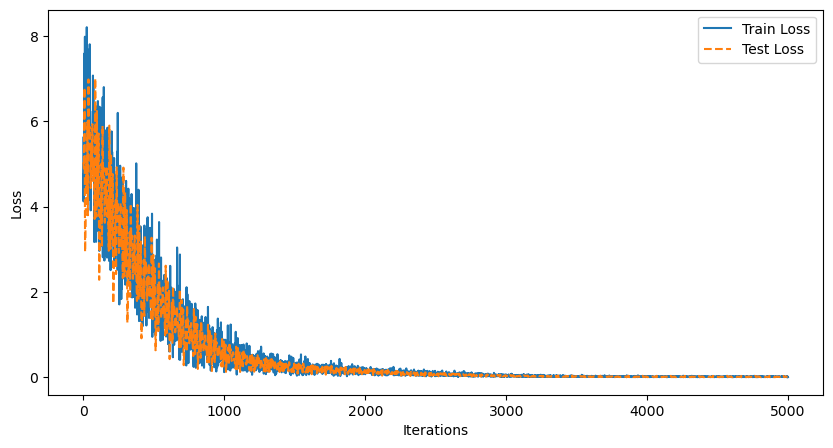

In [20]:
# plot the losses per epoch. normalize the x-axis s.t. the train and test losses are on the same scale
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(train_losses)), train_losses, label="Train Loss", linestyle="-")
plt.plot(np.linspace(0, len(train_losses), len(test_losses), endpoint=False), test_losses, label="Test Loss", linestyle="--")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [25]:
# inference 
x = torch.tensor([0.2324])
y = torch.tensor([2 * x + 1])
y_pred = model(x)

print(f"True: {y.item():.4f} | Pred: {y_pred.item():.4f}")

True: 1.4648 | Pred: 1.4681
